In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MultipleLocator

from formatting_utils import (collate_and_bkgd_sub, 
                              generate_stat_table, 
                              meanlines,
                              plot_puncta,
                              stacked_h_bar_graph,
                              stacked_h_bar_graph_fromdf)

from linescan_utils import build_aggregate_linescan_df, plot_linescan_means

In [2]:
PATH_to_csv_storage = './data_files/'

In [3]:
#global plotting defaults
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 12 #best to use 12 and then make plots 50% in InDesign rather than set font=6
sns.set_style("ticks")

# Plot cyst_to_tube over time

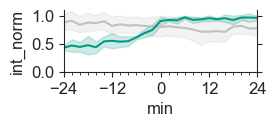

In [30]:
df = pd.read_csv('./data_files/20141001_data', sep='\t')
#mean and stdev of 4 embryos aligned in time (cyst2tube complete = 0) #

fig, ax = plt.subplots(figsize=(2.5,0.8))
sns.lineplot(x="min", 
             y="int_norm", 
             err_style="band",
             errorbar ='sd', 
             estimator=np.mean, 
             data=df, 
             color="#c0c0c0")

sns.lineplot(x="min", 
             y="coverage", 
             err_style="band",
             errorbar ='sd', 
             estimator=np.mean, 
             data=df, 
             color='#079885')

sns.despine(top=True, left=False, right=False, bottom=False);
ax.tick_params(top=False, right=True, left=True, bottom=True); 

plt.xlim(-24, 24)
plt.ylim(0,1.1)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_locator(MultipleLocator(12))
ax.xaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(2))

plt.show()
#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/20241001_JLF913timecourses.pdf', bbox_inches="tight") #bbox_inches = 'tight' to avoid text being cut off of pdf


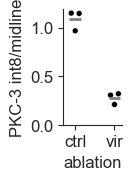

In [32]:
# Background subtracted PKC-3 intensity at int8 nuclei relative to dorsal intestinal midline 
# ratio is from measurements performed in imageJ
# TODO: pull intensity measurements with file names into csv and recreate ablation_data df from that

ablation_data = pd.DataFrame({
        'ablation': ['ctrl', 'ctrl', 'ctrl', 'vir', 'vir', 'vir'],
        'relative PKC-3 intensity': [1.149829233,1.146437662,0.967611336,0.208495707,0.305334658,0.319143299],
        'x_values': [-.1,0.1,0,1,0.9,1.1]
    })
mean_values = ablation_data.groupby('ablation')['relative PKC-3 intensity'].mean()

plt.figure(figsize=(.75, 1.5))
ax = sns.scatterplot(x='x_values', y='relative PKC-3 intensity', data=ablation_data, color='black', size=0.5, legend=False)
sns.despine()

for i, catagory in enumerate(mean_values.index):
        mean = mean_values[catagory]
        ax.hlines(mean, i - 0.15, i + 0.15, color='gray', linestyle='-', linewidth=2, label='Mean' if i == 0 else "")
plt.ylim(0,1.19)
plt.xlim(-.3,1.18)
ax.set_xticks(range(2))
ax.set_xticklabels(['ctrl','vir'])   
ax.set_xlabel("ablation")
ax.set_ylabel("PKC-3 int8/midline")

plt.show()
#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/JLF914_ablationPKC.svg', format='svg')

In [34]:
t_statistic, p_value = stats.ttest_ind(
    ablation_data[ablation_data['ablation']=='ctrl']['relative PKC-3 intensity'].values,
    ablation_data[ablation_data['ablation']=='vir']['relative PKC-3 intensity'].values
)

print(f"\nTwo-Sample Independent T-Test of PKC-3 in ctrl vs vir ablation:")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")


Two-Sample Independent T-Test of PKC-3 in ctrl vs vir ablation:
T-statistic: 11.6550
P-value: 0.0003


puncta quantification is from running get_pts on indicated files

virA corresponds to intestine-facing puncta and virP to rectal-facing puncta

# colocalization of PAR-6vir and PKC-3
data from imageJ PlotProfile (6-8um linescans from rectum to intestine (embryo A->P axis)) and associated Gaussian fits

In [14]:
data_dir = './data_files/20230603_1-5fold_puncta_linescans/'
df_dict = build_aggregate_linescan_df(data_dir)

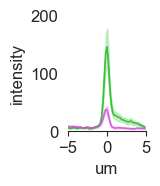

In [15]:
plot_linescan_means(df_dict['df_rect_interpolationM'])
#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/20230602_JLF1440_rectLineplots_n12.pdf', bbox_inches="tight") #bbox_inches = 'tight' to avoid text being cut off of pdf

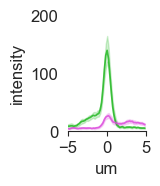

In [16]:
plot_linescan_means(df_dict['df_int_interpolationM'])

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/20230602_JLF1440_intLineplots_n12.pdf', bbox_inches="tight") #bbox_inches = 'tight' to avoid text being cut off of pdf

# Analysis of vir PKC-3 in PAA-1gut(-) worms 

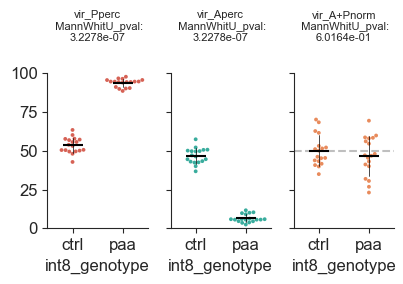

In [6]:
data = pd.read_csv(os.path.join(PATH_to_csv_storage,'20250910_JLF1034_all_correctOrder.csv'))

#comma separated genotype file
geno = pd.read_csv(os.path.join(PATH_to_csv_storage,'JLF1034_genotypes.txt'))

#collect PKC-3 data and background subtract and merge with genotype information
data_collate = collate_and_bkgd_sub(data, 'mean_intensity_PKC-3')
data_collate = data_collate.merge(geno, on='file_name', how='left')


#normalize to total vir intensity (vir_A+P) to mean of all "control" embryos
LCctrl_AP_mean = data_collate['vir_A+P'][data_collate['genotype']=='ctrl'].mean()
data_collate['vir_A+Pnorm'] = data_collate['vir_A+P']/LCctrl_AP_mean * (1/2)*100

RKNctrl_AP_mean = data_collate['vir_A+P'][data_collate['genotype']=='RKNctrl'].mean()
data_collate.loc[data_collate['person']=='RKN', 'vir_A+Pnorm'] = data_collate['vir_A+P']/RKNctrl_AP_mean * (1/2)*100

#use .copy() to suppress SettingWithCopyWarning
dc = data_collate[['file_name','person','genotype','int8_genotype',
                   'vir_A_bs','vir_A+P','vir_A+Pnorm','vir_Aperc','vir_Pperc']].copy()
dc['vir_Pperc'] = dc['vir_Pperc']*100 #make percent

#LC and RKN imaging parameters are too far off to combine these data for quantification unfortunately
dc = dc[dc['person']=='LC'].copy()

#generate stat table for both parametric and nonparametric tests
val_list = ['vir_Pperc','vir_Aperc','vir_A+Pnorm']
order = ['ctrl','paa']
stat_table = generate_stat_table(dc, val_list, 'int8_genotype', order[0], order[1])


#plot % virP, % virA, and total
# TODO: remake plot puncta function to make either a two or a three panel image.
vars1 = dict(x='int8_genotype', y='vir_Pperc')
vars2 = dict(x='int8_genotype', y='vir_Aperc')
vars3 = dict(x='int8_genotype', y='vir_A+Pnorm')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4.2,3))

ax1 = sns.swarmplot(data=dc, **vars1, ax=ax1, alpha=.8, size=2.75,
                    order=order, hue='int8_genotype', palette=['#cc3b2b','#cc3b2b'] #rust, rust
)
meanlines(data=dc, ax=ax1, **vars1)
sns.pointplot(data=dc, **vars1, ax=ax1, 
              color="black", linestyle='none', errorbar='sd', markers='', linewidth=0.5, order=order,zorder=10)
ax1.set_ylim(0, 100);
ax1.set_ylabel('');
pval = stat_table['MannWhitU_pval'].loc[stat_table['value'] == vars1['y']].reset_index(drop=True)
ax1.set_title(vars1['y'] + "\n " + pval.name + ":\n" + str(f"{pval[0][0]:.4e}") + "\n\n", fontsize=8);

ax2 = sns.swarmplot(data=dc, **vars2, 
                    ax=ax2, alpha=.8, size=2.75,
                    order=order, hue='int8_genotype',
                   palette=['#079885','#079885'] #teal, teal)
                   )
meanlines(data=dc, ax=ax2, **vars2)
sns.pointplot(data=dc, **vars2, ax=ax2, 
              color="black", linestyle='none', errorbar='sd', markers='', linewidth=0.5, order=order,zorder=10)
ax2.set_ylim(0, 100);
ax2.set_ylabel('');
ax2.set_yticklabels('');
pval = stat_table['MannWhitU_pval'].loc[stat_table['value'] == vars2['y']].reset_index(drop=True)
ax2.set_title(vars2['y'] + "\n " + pval.name + ":\n" + str(f"{pval[0][0]:.4e}") + "\n\n", fontsize=8);

ax3 = sns.swarmplot(data=dc, **vars3, 
                    ax=ax3, alpha=.8, size=2.75,
                    order=order, hue='int8_genotype',
                   palette=['#e36e33','#e36e33']#orange
                   )
plt.axhline(y=50, color='grey', alpha=.5, linestyle='--')
meanlines(data=dc, ax=ax3, **vars3)
sns.pointplot(data=dc, **vars3, ax=ax3, 
              color="black", linestyle='none', errorbar='sd', markers='', linewidth=0.5, order=order,zorder=10)
sns.despine()
ax3.set_ylabel('');
ax3.set_yticklabels('');
ax3.set_ylim(0, 100);
pval = stat_table['MannWhitU_pval'].loc[stat_table['value'] == vars3['y']].reset_index(drop=True)
ax3.set_title(vars3['y'] + "\n " + pval.name + ":\n" + str(f"{pval[0][0]:.4e}") + "\n\n", fontsize=8);

plt.tight_layout()

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/JLF1034paa_withrect.pdf', format='pdf')

# PLK-1gut(-) PAR-6vir puncta

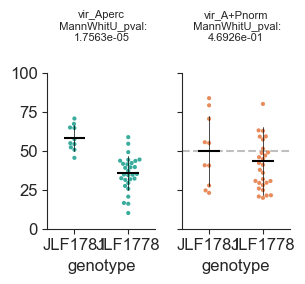

In [7]:
data = pd.read_csv(os.path.join(PATH_to_csv_storage,'202412_JLF1778_JLF1781_v4.csv'))

#collate data
data_collate = collate_and_bkgd_sub(data, 'mean_intensity_P6_vir')

#use strain info to find controls for normalization
strain = []
for i in range(len(data_collate.index)):
    strain.append(data_collate.index.str.split('_',expand=True)[i][1])
data_collate['strain'] = strain

dc = data_collate[['vir_A_bs','vir_P_bs','vir_A+P','vir_Aperc','strain']].copy()
ctrl_AP_mean = dc['vir_A+P'][dc['strain']=='JLF1781'].mean()
dc['vir_A+Pnorm'] = dc['vir_A+P']/ctrl_AP_mean * (1/2) *100
dc['genotype'] = dc['strain']


val_list = ['vir_Aperc','vir_A+Pnorm']
geno_col = 'genotype'
geno_order = ['JLF1781','JLF1778']
stat_table = generate_stat_table(dc, val_list, geno_col, geno_order[0], geno_order[1])
plot_puncta(dc, 
                  dict(x=geno_col, y=val_list[0]), 
                  dict(x=geno_col, y=val_list[1]), 
                  geno_order,
                  stat_table)

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/JLF1781_1778plk_wow181.pdf', format='pdf')

# Analysis of HMR-1 and PKC-3 in HMR_1Ex111 embryos (JLF1089) analysis

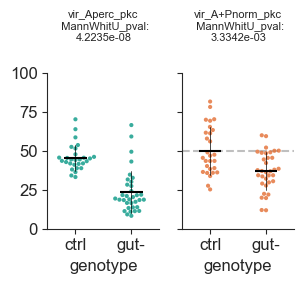

In [8]:
data = pd.read_csv(os.path.join(PATH_to_csv_storage,'20250318_JLF1089_all.csv'))
geno = pd.read_csv(PATH_to_csv_storage+"JLF1089_genotypes")

data_collate_H = collate_and_bkgd_sub(data, 'mean_intensity_HMR-1').reset_index()
dc_hmr = data_collate_H[['file_name','vir_A_bs','vir_P_bs','vir_A+P','vir_Aperc']]
data_collate_P = collate_and_bkgd_sub(data, 'mean_intensity_PKC-3').reset_index()
dc_pkc = data_collate_P[['file_name','vir_A_bs','vir_P_bs','vir_A+P','vir_Aperc']].copy()
dc = pd.merge(dc_hmr,dc_pkc, suffixes=("_hmr", "_pkc"), on='file_name')
dc = dc.merge(geno,on='file_name',how='left')

ctrl_mean_pkc = dc.loc[dc['genotype']=='ctrl','vir_A+P_pkc'].mean()
dc['vir_A+Pnorm_pkc'] = dc.loc[:,'vir_A+P_pkc']/ctrl_mean_pkc*100*(1/2)
ctrl_mean_hmr = dc.loc[dc['genotype']=='ctrl','vir_A+P_hmr'].mean()
dc['vir_A+Pnorm_hmr'] = dc.loc[:,'vir_A+P_hmr']/ctrl_mean_hmr*100*(1/2)

val_list = ['vir_Aperc_pkc','vir_A+Pnorm_pkc','vir_Aperc_hmr','vir_A+Pnorm_hmr']
geno_col = 'genotype'
geno_order = ['ctrl','gut-']
stat_table = generate_stat_table(dc, val_list, 'genotype', geno_order[0], geno_order[1])

#plot pkc
plot_puncta(dc, 
            dict(x=geno_col, y=val_list[0]), 
            dict(x=geno_col, y=val_list[1]), 
            geno_order,
            stat_table)

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/JLF1089_pkc.pdf', format='pdf')

/Users/lecote/anaconda3/envs/devbio-napari-env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


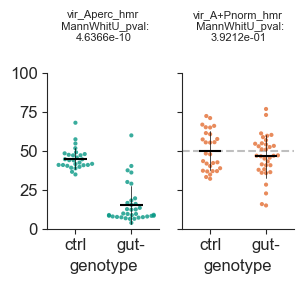

In [9]:
#plot hmr-1
plot_puncta(dc, 
            dict(x=geno_col, y=val_list[2]), 
            dict(x=geno_col, y=val_list[3]), 
            geno_order,
            stat_table)
#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/JLF1089_hmr.pdf', format='pdf')

# PAR-3gut(-) with and without maternal PAR-3 puncta
gut(dark) is hT2- progeny from hT2+ mothers. gut(-) is progeny from hT2- mothers. control are wowEx111 negative 

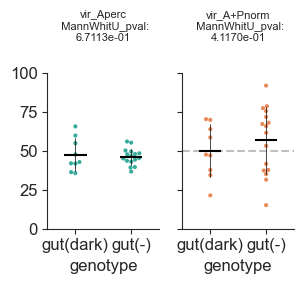

In [10]:
data = pd.read_csv(os.path.join(PATH_to_csv_storage,'20211107_JLF1169_all.csv'))
data['file_name'] = data['index'].str.split(':', expand=True).iloc[:,0]

data_collate = collate_and_bkgd_sub(data, 'mean_intensity_PAR-3')
geno = pd.read_csv(os.path.join(PATH_to_csv_storage,'20211107_JLF1169_genotypes.txt'))
data_collate = data_collate.merge(geno,on='file_name',how='left')

dc= data_collate.loc[:,('vir_A_bs','vir_P_bs','vir_A+P','vir_Aperc','genotype')]
ctrl_AP_mean = dc['vir_A+P'][dc['genotype']=='gut(dark)'].mean()
dc['vir_A+Pnorm'] = dc.loc[:,('vir_A+P')]/ctrl_AP_mean *(1/2) * 100
genotype_list = ['gut(dark)','gut(-)']
dc = dc.loc[(dc['genotype'].isin(genotype_list))]

val_list = ['vir_Aperc','vir_A+Pnorm']
geno_col = 'genotype'
geno_order = ['gut(dark)','gut(-)']
stat_table = generate_stat_table(dc, val_list, 'genotype', geno_order[0], geno_order[1])
plot_puncta(dc, 
            dict(x=geno_col, y=val_list[0]), 
            dict(x=geno_col, y=val_list[1]), 
            geno_order,
            stat_table)


#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/JLF1169_par3.pdf', format='pdf')

# HMR-1gut(-) with and without untagged maternal HMR-1 puncta

/Users/lecote/anaconda3/envs/devbio-napari-env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


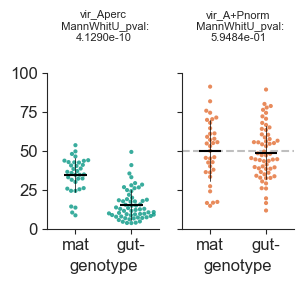

In [11]:
data25 = pd.read_csv(os.path.join(PATH_to_csv_storage,'20210325_JLF1010_all.csv'))
data25['file_name'] = data25['index'].str.split(':', expand=True).iloc[:,0]
data24 = pd.read_csv(os.path.join(PATH_to_csv_storage,'20210324_JLF1010_all.csv'))
data24['file_name'] = data24['index'].str.split(':', expand=True).iloc[:,0]
data = pd.concat([data24, data25], axis=0, ignore_index=True).reset_index()

data_collate = collate_and_bkgd_sub(data, 'mean_intensity_HMR-1')
data_collate['genotype'] = list(pd.DataFrame(data_collate.index)['file_name'].apply(lambda x: 'gut-' if 'nohT2' in x else 'mat'))

dc= data_collate[['vir_A_bs','vir_P_bs','vir_A+P','vir_Aperc','genotype']].copy()
ctrl_AP_mean = dc['vir_A+P'][dc['genotype']=='mat'].mean()
dc['vir_A+Pnorm'] = dc['vir_A+P']/ctrl_AP_mean * 100*(1/2)

#list of normalized values to plot in separate graphs
val_list = ['vir_Aperc','vir_A+Pnorm']

#genotype column and (ctrl, expt) order
geno_col = 'genotype'
geno_order = ['mat','gut-']
stat_table = generate_stat_table(dc, val_list, 'genotype', geno_order[0], geno_order[1])
plot_puncta(dc, 
            dict(x=geno_col, y=val_list[0]), 
            dict(x=geno_col, y=val_list[1]), 
            geno_order,
            stat_table)

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/JLF1010_hmr1mat.pdf', format='pdf')

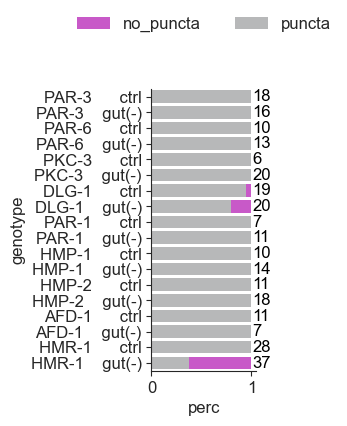

In [29]:
puncta_screen = pd.read_csv("./data_files/puncta_screen_n.csv")

stacked_h_bar_graph_fromdf(puncta_screen, figsize=(3, 4.5), palette=['#db46db','#b7b8b9'])

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/puncta_n_h.pdf', bbox_inches="tight")

# rectal length

In [19]:
df = pd.read_csv('./data_files/vir_ablations_rectal_len.txt', sep="\t", header=0)
group_a = df[df['ablation'] == 'PVT']['rectal len']
group_b = df[df['ablation'] == 'ctrl']['rectal len']
group_c = df[df['ablation'] == 'vir']['rectal len']

    # Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(group_a, group_b, group_c)
print(f"F-statistic: {f_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

F-statistic: 0.87
P-value: 0.429


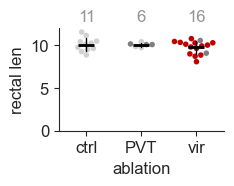

In [20]:
plt.figure(figsize=(2.5, 2.1))
desired_order = ['ctrl','PVT','vir']

sns.swarmplot(data=df, x='ablation', y ='rectal len', hue='phenotype', legend=False,
             palette = ['#d1d1d1', '#c00000', '#7f7f7f'], order=desired_order, alpha=1, s=4,
             zorder=1)
sns.pointplot(x='ablation',y='rectal len',data=df, estimator=np.mean, errorbar='sd',
             order=desired_order, marker='_', markersize=12, 
              markeredgecolor = 'black', alpha=1, linestyle="",
             err_kws={"color": "black", "linewidth": 1})
plt.ylim(0,12);
 
for i, n in enumerate(df.groupby('ablation').size().reindex(desired_order)):
    plt.text(i, 13.5, str(n), ha='center', va='center_baseline', color="#939598")
sns.despine()
plt.tight_layout();

#plt.savefig('/Users/lecote/Projects/napari/valve_morph/rectal_length.pdf', bbox_inches="tight")

# HMR-1nhr-67(-) data

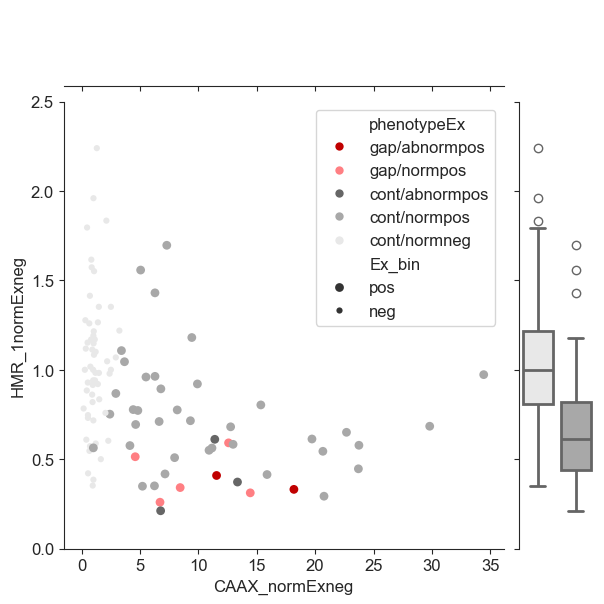

In [ ]:
#bkgd_sub and found that best to normalize to median of Ex_neg by each imaging day since 0505 used different exposure time
#TODO: pull measurment data from excel files and recreate normalization in python
#TODO: recreate stacked bar graph from data["phenotypeEx"] rather than excel

data = pd.read_csv(os.path.join(PATH_to_csv_storage,'jlf1817_bkgdsub_DayExNegMedianNorm.csv'), sep='\t')
data["Ex"] = np.where(data["Ex_bin"]=="pos", 2,1)
data["phenotypeEx"]=data['phenotype']+data["Ex_bin"]

g = sns.JointGrid()
x, y, p, e = data["CAAX_normExneg"], data["HMR_1normExneg"], data["phenotypeEx"], data["Ex_bin"]

sns.scatterplot(x=x, y=y, ax=g.ax_joint, hue=p, palette=['#c00000','#ff7f83','#666666','#a8a8a8','#e8e8e8'],
                hue_order=["gap/abnormpos","gap/normpos","cont/abnormpos","cont/normpos","cont/normneg"],
                size=e, size_order=["pos","neg"],sizes=[40,20],linewidth=0)
plt.xlim(-1,40)              
plt.ylim(0,2.5)
sns.boxplot(y=y, x=e, linewidth=2, ax=g.ax_marg_y, hue=e, palette=['#e8e8e8','#a8a8a8'])

plt.show()
#plt.savefig('/Users/lecote/Projects/napari/valve_paper/puncta quantification/plots/JLF1817_virMem.svg', format='svg')

# Bargraph of wow181 localization data


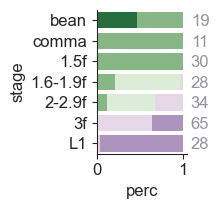

In [18]:
wow181df = pd.read_csv('./data_files/wow181_morphologiesT.txt', sep="\t", header=1, index_col=0)
wow181df = wow181df.rename_axis('desc', axis='columns')
wow181df_perc = wow181df.div(wow181df.sum(axis=1), axis=0)

plt.figure(figsize=(2.5, 2.25))

sns.barplot(data=wow181df_perc.cumsum(axis=1).stack().reset_index(name='perc'),
            x='perc', 
            y='stage', 
            hue='desc',
            hue_order = wow181df_perc.columns[::-1],  # reverse hue order so that the taller bars got plotted first
            palette = ['#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837'],
            dodge=False, 
            legend=False, 
            edgecolor='none', 
            linewidth=0) 

for i, n in enumerate(wow181df.sum(axis=1)):
    plt.text(1.2, i, str(n), ha='center', va='center_baseline', color="#939598")
sns.despine()
plt.tight_layout();

#plt.savefig('/Users/lecote/Projects/napari/valve_morph/wow181_morphologies.pdf', bbox_inches="tight")

# mitotic regulator data 
Plot gaps and mitoses information layered onto cell count at each stage
data is from MS scoring

/Users/lecote/anaconda3/envs/devbio-napari-env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 53.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lecote/anaconda3/envs/devbio-napari-env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lecote/anaconda3/envs/devbio-napari-env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lecote/anaconda3/envs/devbio-napari-env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

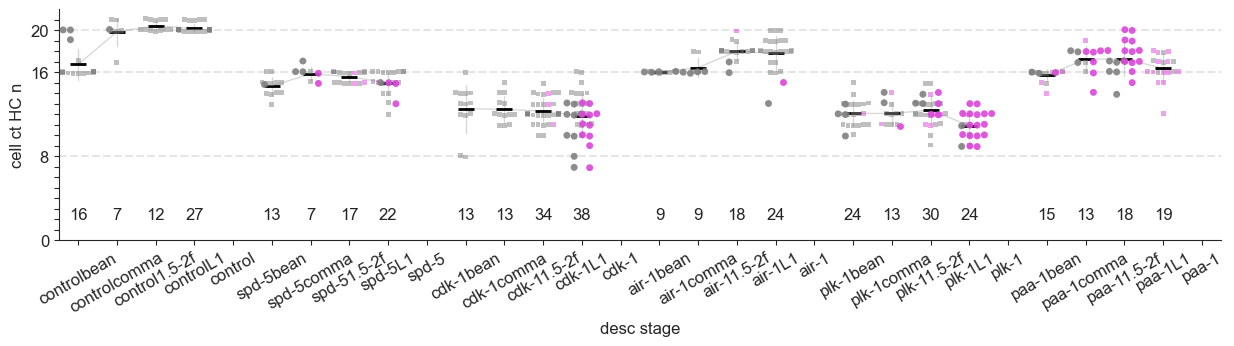

In [22]:
df = pd.read_csv('./data_files/MS_scoring_LCcollate.tsv',sep="\t")

df['cell ct HC n'] = pd.to_numeric(df['cell ct HC'], errors='coerce');
df['desc stage'] = df['desc']+df['collapsed_stage']

#create desired ordering for graph
desired_geno_order = ['control','spd-5','cdk-1','air-1','plk-1','paa-1']
desired_order = []
for g in desired_geno_order:
    desired_order.append([g+'bean',g+'comma',g+'1.5-2f',g+'L1',g])
desired_order = np.array(desired_order).flatten().tolist()

#add noise to integer cell count to jitter the pointplot for visibility
noise = np.random.uniform(-.1, 0.1, len(df))
df['cell ct HC n jitter'] = df['cell ct HC n']+noise


##plot
plt.figure(figsize=(15, 3))

#plot means and stdev of cell counts (found it easiest to plot them separately to change colors)
g = sns.pointplot(x='desc stage',y='cell ct HC n',data=df, estimator=np.mean, errorbar='sd',
             order=desired_order, color='grey', marker='', markersize=12, markeredgecolor = 'black', alpha=.3, linewidth=1)
g = sns.pointplot(x='desc stage',y='cell ct HC n',data=df, estimator=np.mean, errorbar=None,
             order=desired_order, marker='_', markersize=12, markeredgecolor = 'black', alpha=1, linestyle="")

##For L1 data, I set 'P* mitosis any' is True if there is one cell in posterior, false if two cells in int9, so it can all plot together. 
## PAA-1 L1s lack CAAX, so cell count estimate and can't say if only one cell, so am adding overlay in actual figure.

#plot nonmitotic cells (Gray) and then mitotic cells (magenta and slightly larger) 
## Note that swarmplot (best for distributing points so you can see them) doesn't change marker by a variable, so this is my workaround
g = sns.swarmplot(x='desc stage',y='cell ct HC n jitter',data=df[df['P* mitosis any'] ==False], 
                  hue = 'P* gap', marker = 's', s=3.5, order=desired_order, 
                  alpha=.5, palette=['grey','#db46db'], dodge=False)
g = sns.swarmplot(x='desc stage',y='cell ct HC n jitter',data=df[df['P* mitosis any'] ==True], hue = 'P* gap', 
                   marker = 'o' , s=5,
             order=desired_order, alpha=.9, palette=['grey','#db46db'], dodge=True)
g.legend_.remove()

#add number of embryos n onto graphs
y_value_for_ns = 2
for i, n in enumerate(df[df['cell ct HC n'].notna()].value_counts('desc stage').reindex(desired_order)):
    if str(n) == 'nan':
        t = ""
    elif len(str(n))>3:
        t = str(n)[:2]
    else:
        t = str(n)[:1]
    plt.text(i, y_value_for_ns, t, ha='center')
    
#plot normal number of gut cells as horizontal lines
[plt.axhline(y=wt_num, color='grey', alpha=.2, linestyle='--') for wt_num in [8,16,20]]
plt.ylim(0,22);
sns.despine()

#ticks with labels only at normal number of gut cells
plt.yticks(np.arange(0, 22, step=1), ['0',"","","","","","","",8,"","","","","","","",16,"","","",20,""])
plt.xticks(rotation=30); #still offset, but am remaking labels in figure
#plt.savefig('/Users/lecote/Projects/napari/valve_paper/kinases/cell_counts_kinases.pdf', bbox_inches="tight") #bbox_inches = 'tight' to avoid text being cut off of pdf
plt.show()

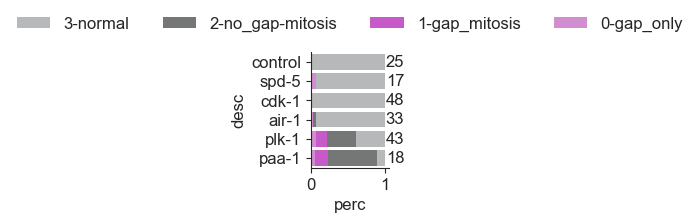

In [23]:
stage_list = ['1.5f','1.8f','2f']

def categorize_A_cells(row):
    if row['A* gap'] == True and row['A* mitosis any'] == False:
        return '0-gap_only'
    elif row['A* gap'] == True and row['A* mitosis any'] == True:
        return '1-gap_mitosis'
    elif row['A* gap'] == False and row['A* mitosis any'] == True:
        return '2-no_gap-mitosis'
    else:
        return '3-normal'

df['A_star_cells'] = df.apply(categorize_A_cells, axis=1)
df_staged = df[df['stage'].isin(stage_list)]

x_var, y_var = "desc", "A_star_cells"

stacked_h_bar_graph(df_staged, x_var, y_var, desired_geno_order)

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/kinases/bargraph_GAP_Amitosis_emb_1.5-2f_h.pdf', bbox_inches="tight")


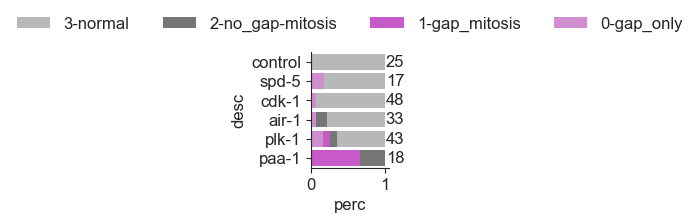

In [24]:
def categorize_P_cells(row):
    if row['P* gap'] == True and row['P* mitosis any'] == False:
        return '0-gap_only'
    elif row['P* gap'] == True and row['P* mitosis any'] == True:
        return '1-gap_mitosis'
    elif row['P* gap'] == False and row['P* mitosis any'] == True:
        return '2-no_gap-mitosis'
    else:
        return '3-normal'

df['P_star_cells'] = df.apply(categorize_P_cells, axis=1)

x_var, y_var = "desc", "P_star_cells"
df_staged = df[df['stage'].isin(stage_list)]

stacked_h_bar_graph(df_staged, x_var, y_var, desired_geno_order)

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/kinases/bargraph_GAP_Pmitosis_emb_1.5-2f_h.pdf', bbox_inches="tight")

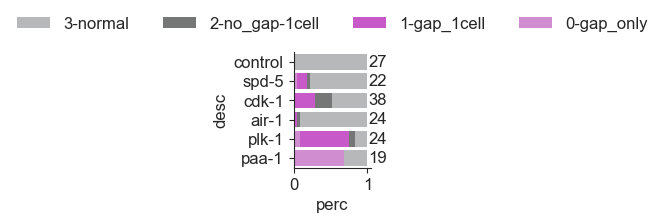

In [25]:
stage_list = ['L1']

def categorize_P_1cell(row):
    if row['P* gap'] == True and row['P* mitosis any'] == False:
        return '0-gap_only'
    elif row['P* gap'] == True and row['P* mitosis any'] == True:
        return '1-gap_1cell'
    elif row['P* gap'] == False and row['P* mitosis any'] == True:
        return '2-no_gap-1cell'
    else:
        return '3-normal'

df['P_star_cells'] = df.apply(categorize_P_1cell, axis=1)

x_var, y_var = "desc", "P_star_cells"
df_staged = df[df['stage'].isin(stage_list)]

stacked_h_bar_graph(df_staged, x_var, y_var, desired_geno_order)

#33/35 with posterior gap are one cell-ed

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/kinases/bargraph_GAP_onecell_L1_h.pdf', bbox_inches="tight")

/Users/lecote/Projects/napari/vir_paper_refactored_code/formatting_utils.py:182: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


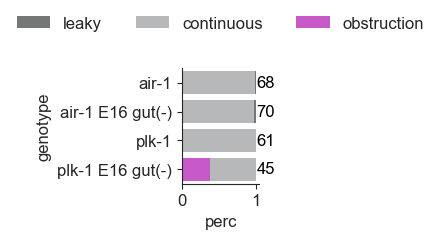

In [26]:
# L1 Smurf assay data from MS
L1_smurf = pd.DataFrame({'genotype':['air-1', 'air-1 E16 gut(-)','plk-1', 'plk-1 E16 gut(-)'],
                         'obstruction':[0, 0, 0,17], 
                         'continuous':[67, 68, 61, 28], 
                         'leaky': [1,2,0,0]})

stacked_h_bar_graph_fromdf(L1_smurf)

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/kinases/L1_smurf_h.pdf', bbox_inches="tight")

/Users/lecote/Projects/napari/vir_paper_refactored_code/formatting_utils.py:182: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


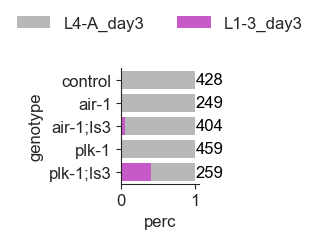

In [27]:
# day3 larval stages from MS. Sum of 3 replicates.
larval_growth = pd.DataFrame({'genotype':['control','air-1','air-1;Is3','plk-1','plk-1;Is3'],
                             'L1-3_day3':[0,0,23,1,104],
                            'L4-A_day3':[428,249,381,458,155]})

stacked_h_bar_graph_fromdf(larval_growth, palette=['#b7b8b9','#db46db'])

#plt.savefig('/Users/lecote/Projects/napari/valve_paper/kinases/Larval_Growth_h.pdf', bbox_inches="tight")